# 1.Data Collection:


Allergen Proteins->"Allergen OR Allergenic OR ALLERG" -> 2170 proteins

Non Allergen Proteins ->"NOT Allergen AND NOT Allergenic AND NOT ALLERG" -> 567,346 proteins

# Protein sequences

A-Alanine(1)      C-Cysteine(2)   D-Aspartic Acid(3)  E-Glutamic Acid(4)   F-Phenylalanine(5)  G-Glycine(6)   H-Histidine(7)

I-Isoleucine(8)   K-Lysine(9)     L-Leucine(10)       M-Methionine(11)     N-Asparagine(12)    P-Proline(13)  Q-Glutamine(14)

R-Arginine(15)    S-Serine(16)    T-Threonine(17)     V-Valine(18)         W-Tryptophan(19)    Y-Tyrosine(20)


X-Any AA(0)        

# Unknown
B-Asparagine OR Aspartic acid AND J-Leucine OR Isoleucine and O-Pyrrolysine and  U-Selenocysteine Z-Glutamine or Glutamic Acid

# References:

https://www.uniprot.org/uniprotkb?facets=reviewed%3Atrue&query=Allergen%20OR%20Allergenic%20OR%20ALLERG ALLERGENIC dataset

https://www.uniprot.org/uniprotkb?facets=reviewed%3Atrue&query=NOT%20Allergen%20AND%20NOT%20Allergenic%20AND%20NOT%20ALLERG 
NOT ALLERGENIC DATASET

https://coding4medicine.com/backup/Python/reading-fasta-files.html  to read FASTA files

https://meme-suite.org/meme/doc/alphabets.html and  https://www.ddbj.nig.ac.jp/ddbj/code-e.html  Protein alphabet

In [6]:
import sys, re
from Bio import SeqIO
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import random

import torch
import torch.nn as nn  
import torch.optim as optim  
import torchvision.transforms as transforms  
import torchvision
from torch.utils.data import (Dataset,DataLoader)
import torch
from torch.utils.data import Dataset, DataLoader

# 1.1 Allergen protein analysis

In this section the file containing the allergenic proteins is analyzed and filtered appropriately

<re.Match object; span=(0, 25), match='>sp|A0A1J1DL12|RIDA_DERFA'>
MSPKRIISTPLAPQPIGPYSQAVQVGNTVYLSGQIGMNVRTNEMVTGPIRDEAQQAFTNM
Protein with the largest sequence:
ID: sp|Q4WVN4|NRPS8_ASPFU
Sequence Length: 8515
Protein with the smallest sequence:
ID: sp|P81826|MPAJ4_JUNVI
Sequence Length: 5
Mean: 382.4175115207373
Median 273.0
Mode: 134
90th percentile: 731.3999999999996
95th percentile: 1006.0
99th percentile: 1869.549999999982


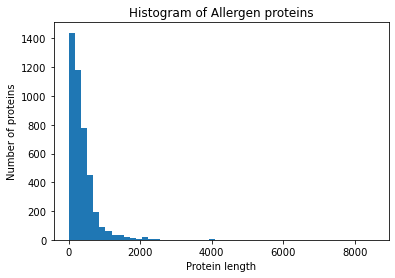

In [2]:
#Extract the protein ID from the known allergen proteins

f=open('Allergen_Proteins.fasta','r') #r=read only
lines=f.readlines()

hre=re.compile('>(\S+)') #search for '>' and return the text that follows '>'
lre=re.compile('^(\S+)$') #Extract the sequence from the known allergen proteins

protein={}

for line in lines:
        outh = hre.search(line)
        if outh:
                id=outh.group(1)
        else:
                outl=lre.search(line)
                if(id in protein.keys()):
                        protein[id] += outl.group(1)
                else:
                        protein[id] =outl.group(1)

#Extract the data for the first protein
outh = hre.search(lines[0])
print(outh)

outl = lre.search(lines[1])
print(outl.group(1))

# Calculate the lengths of all proteins
protein_lengths = [len(sequence) for sequence in protein.values()]


# Calculate the lengths of all proteins
for sequence in protein.values():
    protein_lengths.append(len(sequence))

# Find the protein with the minimum length
min_length = min(protein_lengths)
min_protein_id = [protein_id for protein_id, sequence in protein.items() if len(sequence) == min_length][0]

# Find the protein with the maximum length
max_length = max(protein_lengths)
max_protein_id = [protein_id for protein_id, sequence in protein.items() if len(sequence) == max_length][0]

#Find  mean,median,mode
mean = np.mean(protein_lengths)
median= np.median(protein_lengths)
mode = stats.mode(protein_lengths)

#Find 90th,95th,99th percentile
percentiles = np.percentile(protein_lengths, [90, 95, 99])


print("Protein with the largest sequence:")
print("ID:", max_protein_id)
print("Sequence Length:", max_length)

print("Protein with the smallest sequence:")
print("ID:", min_protein_id)
print("Sequence Length:",min_length)

print("Mean:", mean)
print("Median", median)
print("Mode:", mode[0][0])

print("90th percentile:", percentiles[0])
print("95th percentile:", percentiles[1])
print("99th percentile:", percentiles[2])



# Generate a distribution of protein lengths
length_distribution = {}
for length in protein_lengths:
    if length in length_distribution:
        length_distribution[length] += 1
    else:
        length_distribution[length] = 1
        
# Plot the distribution of protein lengths
plt.hist(protein_lengths, bins=50)
plt.xlabel('Protein length')
plt.ylabel('Number of proteins')
plt.title('Histogram of Allergen proteins')
plt.show()

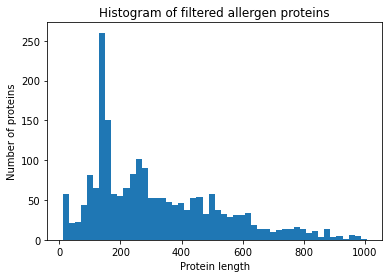

Total proteins left: 2057
Minimum length: 11
Maximum length: 1006
Mean: 315.72873116188623
Median: 263.0
Mode: 134


In [4]:
#Define a class to  filter out  the unwanted proteins
def filter_fasta(input_file, output_file, min_length, max_length):
    with open(input_file, 'r') as f:
        lines = f.readlines()

    filtered_proteins = []
    filtered_lengths = []

    current_protein = None
    current_sequence = []

    for line in lines:
        if line.startswith('>'):
            if current_protein is not None:
                sequence = ''.join(current_sequence)
                sequence_length = len(sequence)
                if min_length <= sequence_length <= max_length:
                    filtered_proteins.append(current_protein + '\n' + sequence)
                    filtered_lengths.append(sequence_length)
            current_protein = line.strip()
            current_sequence = []
        else:
            current_sequence.append(line.strip())

    # Check the last protein after the loop ends
    if current_protein is not None:
        sequence = ''.join(current_sequence)
        sequence_length = len(sequence)
        if min_length <= sequence_length <= max_length:
            filtered_proteins.append(current_protein + '\n' + sequence)
            filtered_lengths.append(sequence_length)

    with open(output_file, 'w') as f:
        f.write('\n'.join(filtered_proteins))

    # Calculate statistics
    total_proteins = len(filtered_proteins)
    min_length = min(filtered_lengths)
    max_length = max(filtered_lengths)
    mean = np.mean(filtered_lengths)
    median= np.median(filtered_lengths)
    mode = stats.mode(filtered_lengths)

    # Plot distribution
    plt.hist(filtered_lengths, bins=50)
    plt.xlabel('Protein length')
    plt.ylabel('Number of proteins')
    plt.title('Histogram of filtered allergen proteins')
    plt.show()

    return total_proteins, min_length, max_length, mean, median, mode

# Usage
total, minimum, maximum,mean,median,mode = filter_fasta('Allergen_Proteins.fasta', 'Filtered_Allergen_Proteins.fasta', 10, 1006)
print("Total proteins left:", total)
print("Minimum length:", minimum)
print("Maximum length:", maximum)
print("Mean:", mean)
print("Median:", median)
print("Mode:", mode[0][0])


In [5]:
# Find the unique amino acids

fasta_file = 'Filtered_Allergen_Proteins.fasta'
with open(fasta_file,'r') as file:
    # Use Biopython's SeqIO to parse the sequences
    sequences = SeqIO.parse(file,"fasta")

    # Initialize a set to store the unique amino acids
    unique_amino_acids = set()

    # Iterate over each sequence
    for sequence in sequences:
        # Convert the sequence to a string
        sequence_str = str(sequence.seq)
        
        # Add each unique amino acid to the set
        unique_amino_acids.update(set(sequence_str))

# Print the unique amino acids
print("Unique Amino Acids:")
print(" ".join(sorted(unique_amino_acids)))



Unique Amino Acids:
A C D E F G H I K L M N P Q R S T V W X Y Z


In [2]:
def map_sequence(sequence, mapping):
    map = [mapping[aa] for aa in sequence if aa in mapping]
    return np.array(map)

def map_fasta(input_file, mapping):
    with open(input_file, 'r') as f:
        lines = f.readlines()

    mapped_sequences = []

    current_protein_id = None
    current_sequence = ''
    for line in lines:
        if line.startswith('>'):
            if current_protein_id and current_sequence:
                mapped_sequence = map_sequence(current_sequence, mapping)
                mapped_sequences.append((current_protein_id, mapped_sequence))
            current_protein_id = line.strip()[1:]
            current_sequence = ''
        else:
            current_sequence += line.strip()

    # Process the last protein sequence
    if current_protein_id and current_sequence:
        mapped_sequence = map_sequence(current_sequence, mapping)
        mapped_sequences.append((current_protein_id, mapped_sequence))

    return mapped_sequences

# Mapping of amino acids to numbers
mapping = {
    'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10,
    'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19,
    'Y': 20, 'X': 0, 'Z': 0
}

# Input FASTA file path
input_file = 'Filtered_Allergen_Proteins.fasta'


mapped_sequences = map_fasta(input_file, mapping)
#for protein_id, sequence in mapped_sequences:
   #print(f'Protein ID: {protein_id}')
    #print(sequence)



# 1.2 Unknown proteins

In this section the file containing the proteins with unkown allergenicity is filtered and analyzed. Initially the file contained more than 500000 protein sequences, however due to the high computational power demand 300000 protein sequences were randomly selected at first.

In [7]:
input_file = 'NOT_Allergen_Proteins.fasta'
output_file = 'Reduced_NOT_Allergen_Proteins.fasta'
selected = 10000


proteins = list(SeqIO.parse(input_file, 'fasta'))


selected_proteins = random.sample(proteins, selected)

# Write the selected protein records to the output file
SeqIO.write(selected_proteins, output_file, 'fasta')

print(f"Selected {selected} proteins and saved them as '{output_file}'.")

Selected 10000 proteins and saved them as 'Reduced_NOT_Allergen_Proteins.fasta'.


<re.Match object; span=(0, 21), match='>sp|Q9SXG8|DOF1_ORYSJ'>
MDAAHWHQGLGLVKPMEEMLMAANAAAGANPNPAATAPSSVTGGALRGGGGGGAPPVAGG
Protein with the largest sequence:
ID: sp|Q8CP76|EBH_STAES
Sequence Length: 9439
Protein with the smallest sequence:
ID: sp|P58705|FFKA_ANTEL
Sequence Length: 4
Mean: 367.7278
Median 297.0
Mode: 156
90th percentile: 676.1000000000022
95th percentile: 901.0499999999993
99th percentile: 1650.0


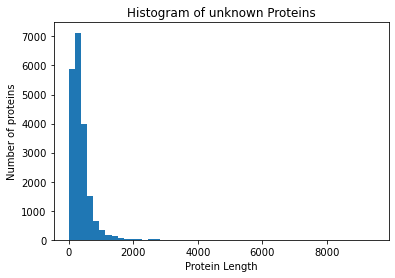

In [8]:
#Extract the protein ID from the unknown allergen proteins

f=open('Reduced_NOT_Allergen_Proteins.fasta','r') #r=read only
lines=f.readlines()

hre=re.compile('>(\S+)') #search for '>' and return the text that follows '>'
lre=re.compile('^(\S+)$') #Extract the sequence from the known allergen proteins

protein={}

for line in lines:
        outh = hre.search(line)
        if outh:
                id=outh.group(1)
        else:
                outl=lre.search(line)
                if(id in protein.keys()):
                        protein[id] += outl.group(1)
                else:
                        protein[id] =outl.group(1)

#Extract the data for the first protein
outh = hre.search(lines[0])
print(outh)

outl = lre.search(lines[1])
print(outl.group(1))

# Calculate the lengths of all proteins
protein_lengths = [len(sequence) for sequence in protein.values()]


# Calculate the lengths of all proteins
for sequence in protein.values():
    protein_lengths.append(len(sequence))

# Find the protein with the minimum length
min_length = min(protein_lengths)
min_protein_id = [protein_id for protein_id, sequence in protein.items() if len(sequence) == min_length][0]

# Find the protein with the maximum length
max_length = max(protein_lengths)
max_protein_id = [protein_id for protein_id, sequence in protein.items() if len(sequence) == max_length][0]

#Find  mean,median,mode
mean = np.mean(protein_lengths)
median= np.median(protein_lengths)
mode = stats.mode(protein_lengths)

#Find 90th,95th,99th percentile
percentiles = np.percentile(protein_lengths, [90, 95, 99])


print("Protein with the largest sequence:")
print("ID:", max_protein_id)
print("Sequence Length:", max_length)

print("Protein with the smallest sequence:")
print("ID:", min_protein_id)
print("Sequence Length:",min_length)

print("Mean:", mean)
print("Median", median)
print("Mode:", mode[0][0])

print("90th percentile:", percentiles[0])
print("95th percentile:", percentiles[1])
print("99th percentile:", percentiles[2])



# Generate a distribution of protein lengths
length_distribution = {}
for length in protein_lengths:
    if length in length_distribution:
        length_distribution[length] += 1
    else:
        length_distribution[length] = 1
        
# Plot the distribution of protein lengths
plt.hist(protein_lengths, bins=50)
plt.xlabel('Protein Length')
plt.ylabel('Number of proteins')
plt.title('Histogram of unknown Proteins')
plt.show()

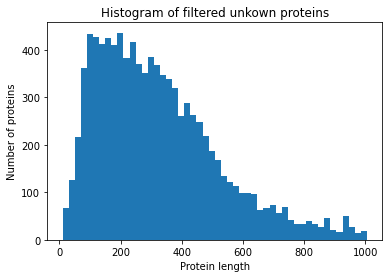

Total proteins left: 9621
Minimum length: 10
Maximum length: 1005
Mean: 321.79056231161
Median: 287.0
Mode: 156


In [12]:
#Define a class to  filter out  the unwanted proteins
def filter_fasta(input_file, output_file, min_length, max_length):
    with open(input_file, 'r') as f:
        lines = f.readlines()

    filtered_proteins = []
    filtered_lengths = []

    current_protein = None
    current_sequence = []

    for line in lines:
        if line.startswith('>'):
            if current_protein is not None:
                sequence = ''.join(current_sequence)
                sequence_length = len(sequence)
                if min_length <= sequence_length <= max_length:
                    filtered_proteins.append(current_protein + '\n' + sequence)
                    filtered_lengths.append(sequence_length)
            current_protein = line.strip()
            current_sequence = []
        else:
            current_sequence.append(line.strip())

    # Check the last protein after the loop ends
    if current_protein is not None:
        sequence = ''.join(current_sequence)
        sequence_length = len(sequence)
        if min_length <= sequence_length <= max_length:
            filtered_proteins.append(current_protein + '\n' + sequence)
            filtered_lengths.append(sequence_length)

    with open(output_file, 'w') as f:
        f.write('\n'.join(filtered_proteins))

    # Calculate statistics
    total_proteins = len(filtered_proteins)
    min_length = min(filtered_lengths)
    max_length = max(filtered_lengths)
    mean = np.mean(filtered_lengths)
    median= np.median(filtered_lengths)
    mode = stats.mode(filtered_lengths)

    # Plot distribution
    plt.hist(filtered_lengths, bins=50)
    plt.xlabel('Protein length')
    plt.ylabel('Number of proteins')
    plt.title('Histogram of filtered unkown proteins')
    plt.show()

    return total_proteins, min_length, max_length, mean,median,mode

# Usage
total, minimum, maximum, mean,median,mode = filter_fasta('Reduced_NOT_Allergen_Proteins.fasta', 'Filtered_NOT_Allergen_Proteins.fasta', 10, 1006)
print("Total proteins left:", total)
print("Minimum length:", minimum)
print("Maximum length:", maximum)
print("Mean:", mean)
print("Median:", median)
print("Mode:", mode[0][0])


In [13]:
#Find the unique amino acids

fasta_file = 'Filtered_NOT_Allergen_Proteins.fasta'
with open(fasta_file,'r') as file:
    # Use Biopython's SeqIO to parse the sequences
    sequences = SeqIO.parse(file,"fasta")

    # Initialize a set to store the unique amino acids
    unique_amino_acids = set()

    # Iterate over each sequence
    for sequence in sequences:
        # Convert the sequence to a string
        sequence_str = str(sequence.seq)
        
        # Add each unique amino acid to the set
        unique_amino_acids.update(set(sequence_str))

# Print the unique amino acids
print("Unique Amino Acids:")
print(" ".join(sorted(unique_amino_acids)))

Unique Amino Acids:
A B C D E F G H I K L M N P Q R S T U V W X Y Z


In [3]:
#convert amino acid sequences to numbers
def map_sequence(sequence, mapping):
    map = [mapping[aa] for aa in sequence if aa in mapping]
    return np.array(map)

def map_fasta(input_file, mapping):
    with open(input_file, 'r') as f:
        lines = f.readlines()

    mapped_sequences = []

    current_protein_id = None
    current_sequence = ''
    for line in lines:
        if line.startswith('>'):
            if current_protein_id and current_sequence:
                mapped_sequence = map_sequence(current_sequence, mapping)
                mapped_sequences.append((current_protein_id, mapped_sequence))
            current_protein_id = line.strip()[1:]
            current_sequence = ''
        else:
            current_sequence += line.strip()

    # Process the last protein sequence
    if current_protein_id and current_sequence:
        mapped_sequence = map_sequence(current_sequence, mapping)
        mapped_sequences.append((current_protein_id, mapped_sequence))

    return mapped_sequences

# Mapping of amino acids to numbers
mapping = {
    'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10,
    'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19,
    'Y': 20, 'X': 0 , 'U': 0, 'B': 0, 'J': 0, 'O': 0,'Z':0
}

# Input FASTA file path
input_file = 'Filtered_NOT_Allergen_Proteins.fasta'


mapped_sequences = map_fasta(input_file, mapping)         

#for protein_id, sequence in mapped_sequences:
    #print(f'Protein ID: {protein_id}')
    #print(sequence)


# 2. Merge the files,put labels and zero-padding

In [2]:
def sequence_padding(sequences, max_length):
    padded_sequences = []
    for seq in sequences:
        padding_length = max_length - len(seq)
        padded_seq = seq + "X" * padding_length  # Padding with a special token, "X"
        padded_sequences.append(padded_seq)
    return padded_sequences

allergen_sequences = []
allergen_headers = []

with open("Filtered_Allergen_Proteins.fasta", "r") as file:
    lines = file.readlines()

for line in lines:
    if line.startswith(">"):
        allergen_headers.append(line.strip())
    else:
        allergen_sequences.append(line.strip())
        
# Randomly select allergen proteins to increase the count up to 5000
while len(allergen_sequences) < 5000:
    random_protein = random.choice(allergen_sequences)
    allergen_sequences.append(random_protein)

non_allergen_sequences = []
non_allergen_headers = []

with open("Filtered_NOT_Allergen_Proteins.fasta", "r") as file:
    lines = file.readlines()

for line in lines:
    if line.startswith(">"):
        non_allergen_headers.append(line.strip())
    else:
        non_allergen_sequences.append(line.strip())

# Step 2: Create a merged dataset
merged_sequences = allergen_sequences + non_allergen_sequences
merged_labels = [1] * len(allergen_sequences) + [0] * len(non_allergen_sequences)

# Shuffle the protein order
merged_data = list(zip(merged_sequences, merged_labels))
random.shuffle(merged_data)
merged_sequences, merged_labels = zip(*merged_data)

# Step 3: Determine the maximum sequence length for padding
max_length = max(len(seq) for seq in merged_sequences)

# Step 4: Apply sequence padding
padded_sequences = sequence_padding(merged_sequences, max_length)

# Step 5: Save the merged dataset with padded sequences
with open("Proteins.fasta", "w") as file:
    for i in range(len(padded_sequences)):
        file.write("> Label:" + str(merged_labels[i]) + "\n")
        file.write(padded_sequences[i] + "\n")

# Print the total number of proteins
total_proteins = len(padded_sequences)
print("Total number of proteins:", total_proteins)

# Print the first 10 proteins
print("First 10 proteins:")
for i in range(10):
    print("Label:", merged_labels[i])
    print("Sequence:", padded_sequences[i])
    print()

Total number of proteins: 14621
First 10 proteins:
Label: 0
Sequence: MARLFVAVALFGVVAFAAAEKEWTGKTWLGSWASTDRAENWEAFVDALGLPSDQYPREVQRTIHTIYKQGDKYHHEVSIPSKNFKKAIEYTLGTETDVQHGPHTIKLKYTEDGEKLVADVQIPSKNKQIHDIYEVQGDTLTKTYKVGDVVAKRWFTREANPTAXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

In [7]:
class ProteinDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]
        return sequence, label

# Load the merged dataset with padded sequences
merged_sequences = []
merged_labels = []

with open("Proteins.fasta", "r") as file:
    lines = file.readlines()

for i in range(0, len(lines), 2):
    sequence = lines[i+1].strip()
    label = int(lines[i].split(":")[1])
    merged_sequences.append(sequence)
    merged_labels.append(label)

amino_acids = "ABCDEFGHIKLMNPQRSTUVWXYZ"

amino_acid_to_idx = {aa: idx for idx, aa in enumerate(amino_acids)}

def one_hot_encode(sequence):
    encoded_sequence = torch.zeros(len(sequence), len(amino_acids))
    for i, aa in enumerate(sequence):
        if aa in amino_acid_to_idx:
            encoded_sequence[i, amino_acid_to_idx[aa]] = 1.0
    return encoded_sequence

# Convert the sequences and labels to PyTorch tensors
merged_labels = torch.tensor(merged_labels)

# Convert sequences to one-hot encoding
encoded_sequences = [one_hot_encode(seq) for seq in merged_sequences]

# 2. Building the model



In [9]:
dataset = ProteinDataset(encoded_sequences, merged_labels)

# Split the dataset into training, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create DataLoader for batch processing
train_loader = DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

print('Train dataset size:', len(train_dataset)) 
print('Validation dataset size:', len(val_dataset)) 
print('Test dataset size:', len(test_dataset))

Train dataset size: 11696
Validation dataset size: 1462
Test dataset size: 1463


In [10]:
#Hyperparameters
epochs = 5 #complete passess over the data set
classes = 2 #allergen or non-allergen
batch_size = 100 #data must be loaded in batches for more efficient training (high batch size can lead to memory overload)
learning_rate = 0.001

For epoch 1 the training loss is 0.6518
The validation loss is 0.6496 and the validation accuracy is 64.50%
For epoch 2 the training loss is 0.6424
The validation loss is 0.6498 and the validation accuracy is 64.50%
For epoch 3 the training loss is 0.6423
The validation loss is 0.6513 and the validation accuracy is 64.50%
For epoch 4 the training loss is 0.6423
The validation loss is 0.6512 and the validation accuracy is 64.50%
For epoch 5 the training loss is 0.6427
The validation loss is 0.6512 and the validation accuracy is 64.50%


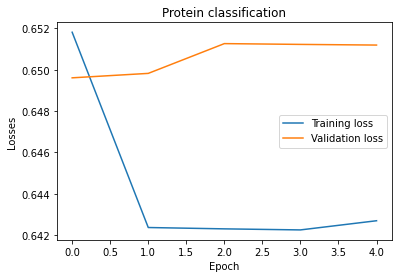

In [15]:
class ConvNet(nn.Module):
    def __init__(self, classes=2):
        super(ConvNet, self).__init__()

        # First layer
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=5, kernel_size=5, stride=2)
        self.relu1 = nn.ReLU()

        # Second layer
        self.conv2 = nn.Conv1d(in_channels=5, out_channels=10, kernel_size=5, stride=2)
        self.relu2 = nn.ReLU()

        # Third layer
        self.conv3 = nn.Conv1d(in_channels=10, out_channels=20, kernel_size=5, stride=2)
        self.relu3 = nn.ReLU()

        # Fully connected layer
        self.fc = nn.Linear(in_features=20, out_features=classes)

    def forward(self, input):
        
        input = input.view(input.size(0), 1, -1)

        output = self.conv1(input)
        output = self.relu1(output)

        output = self.conv2(output)
        output = self.relu2(output)

        output = self.conv3(output)
        output = self.relu3(output)

        # Global average pooling too match mat1 and mat2
        output = torch.mean(output, dim=2)

        output = self.fc(output)

        return output
    
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ConvNet(classes=2).to(device)

# Loss and optimizer functions
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

# Lists to store training and validation losses
train_losses = []
val_losses = []

# Function to evaluate the model on the validation set
def evaluate_model(loader, model):
    model.eval()
    num_correct = 0
    num_total = 0
    total_loss = 0.0

    with torch.no_grad():
        for data, labels in loader:
            data = data.to(device)
            labels = labels.to(device)

            output = model(data)
            loss = criterion(output, labels)
            total_loss += loss.item()

            _, predictions = output.max(1)
            num_correct += (predictions == labels).sum().item()
            num_total += predictions.size(0)
           
            
    model.train()  # Set the model back to training mode
    accuracy = 100.0 * num_correct / num_total
    return total_loss, accuracy



# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    
    for batch_index, (train_data, train_labels) in enumerate(train_loader):
        optimizer.zero_grad()
        train_data = train_data.to(device)
        train_labels = train_labels.to(device)

        # Forward pass
        train_output = model(train_data)
        loss = criterion(train_output, train_labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    # Calculate and store the average training loss for this epoch
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"For epoch {epoch+1} the training loss is {avg_train_loss:.4f}")

    # Evaluate the model on the validation set and store the validation loss
    val_loss, val_accuracy = evaluate_model(val_loader, model)
    val_losses.append(val_loss / len(val_loader))
    print(f"The validation loss is {val_losses[-1]:.4f} and the validation accuracy is {val_accuracy:.2f}%")


# Plot the Train and Validation losses
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Losses")
plt.title("Protein classification")
plt.show()

In [23]:
print("Getting Test set accuracy....")
test_accuracy=evaluate_model(test_loader, model) 
print(f" The total loss and test accuracy are {test_accuracy}")

Getting Test set accuracy....
 The total loss and test accuracy are (9.550253868103027, 66.57552973342447)
